# Exploratory Analysis of parsed data

In [1]:
import os
import pandas as pd

df_articles = pd.read_pickle("../data/processed/parsed_articles.pkl")

<a id="table-of-contents"></a>

## Table of Contents

Overview of parsed data checks to guide data cleaning steps.

1. [High-Level Checks](#data_checks)  
   * Record counts (compared to expectations)
   * Check dates
   * Time distribution plot  

2. [Repeated Headlines](#headlines)  
   * Most frequent headlines  
   * Recurring topics  
   * Quasi-duplicate articles (same headline, similar body)  

3. [Sections Analysis](#sections)  

4. [Potential Issues](#issues)  
   * Working-class keywords review  
   * Data profiling summary


<a id="data_checks"></a>
## 1. High Level Checks 


[⬆ Return to Top](#table-of-contents)

### Record Counts

In [2]:
expected_n_articles = 500 * 86 + 305 + 361
parsed_articles = df_articles.shape[0]

In [3]:
try:
    assert expected_n_articles == parsed_articles, (
        f"Mismatch: expected {expected_n_articles}, got {parsed_articles}"
    )
    print(f"✅ Total number of articles parsed: {parsed_articles} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of articles parsed: 43666 — matches expectations.


In [4]:
expected_n_source_files = 88
parsed_sources_files = len(set(df_articles["source_file"]))

In [5]:
try:
    assert expected_n_source_files == parsed_sources_files, (
        f"Mismatch: expected {expected_n_source_files}, got {parsed_sources_files}"
    )
    print(f"✅ Total number of source files parsed: {parsed_sources_files} — matches expectations.")
except AssertionError as e:
    print(f"❌ There's a mismatch. {e}")


✅ Total number of source files parsed: 88 — matches expectations.


### Check dates

In [6]:
# Check that no date values are missing
missing_dates_count = df_articles['date'].isna().sum()
try:
    assert missing_dates_count == 0, (
        f"Found {missing_dates_count} articles with missing dates:\n"
        f"{df_articles.loc[df_articles['date'].isna()]}"
    )
    print("✅ All articles have a date — expectations met.")
except AssertionError as e:
    print(f"❌ Date check failed. {e}")


✅ All articles have a date — expectations met.


In [7]:
# Validate that all 'date' entries can be parsed into valid dates
try:
    parsed_dates = pd.to_datetime(df_articles["date"], errors="coerce").dt.date
    invalid_dates = df_articles.loc[parsed_dates.isna()]
    invalid_count = invalid_dates.shape[0]

    assert invalid_count == 0, (
        f"Found {invalid_count} articles with invalid or missing dates:\n"
        f"{invalid_dates}"
    )

    print("✅ All articles have valid dates — expectations met.")
except AssertionError as e:
    print(f"❌ Date validation failed. {e}")


✅ All articles have valid dates — expectations met.


In [8]:
print("Number of articles with date at the end: ", 
int(df_articles.apply(lambda x: x['correction_appended'] or x['load_date_at_end'], axis = 1).sum()))

Number of articles with date at the end:  461


### Time Distribution Plot

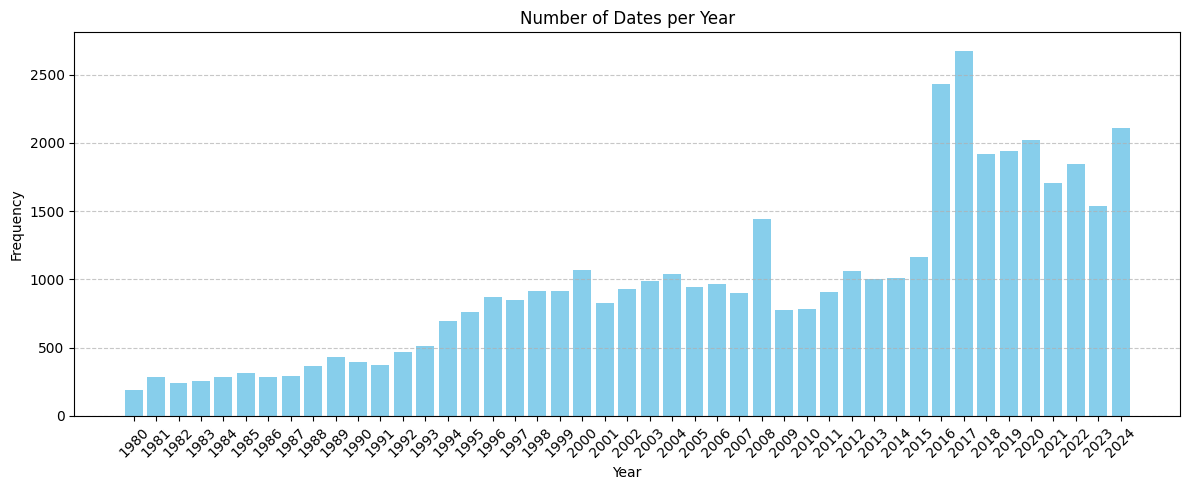

In [9]:
import matplotlib.pyplot as plt
from collections import Counter

# Group by year
years = [d.year for d in parsed_dates]
year_counts = Counter(years)

# Sort by year
sorted_years = sorted(year_counts)
frequencies = [year_counts[year] for year in sorted_years]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(sorted_years, frequencies, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Number of Dates per Year')
plt.xticks(sorted_years, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<a id="headlines"></a>
## 2. Recurring Headlines


[⬆ Return to Top](#table-of-contents)

__To do:__ continue cleaning notebook.

__Question for Elena:__ does she approve the following organizational layout work to document decisions?

* Data processing folder: code + README.md file documentating decisions and reasoning.

* Data exploration folder: exploratory code that systematically analyzed data to arrive at decisions made above.

### Most frequent headlines

In [10]:
highest_frequency_titles = {key:value for key, value in dict(df_articles['title'].value_counts()).items() if value > 100}
highest_frequency_titles

{'No Headline In Original': np.int64(368), 'Movie guide': np.int64(101)}

In [11]:
df_no_headline = df_articles.loc[df_articles["title"] == "No Headline In Original"]
df_no_headline.head(2)

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file
446,No Headline In Original,The New York Times,2024-09-01,Section MB; Column 0; Metropolitan Desk; Pg. 3...,533 words,"\n\nIn the Schools: Dress Codes, Self-Expressi...",False,False,NYT/55.DOCX
457,No Headline In Original,The New York Times,2022-01-30,Section MB; Column 0; Metropolitan Desk; Pg. 3...,774 words,"\n\nHow Fire Defined the Bronx, and Us\nReader...",False,False,NYT/55.DOCX


In [12]:
select_index = 0 # select index to view the body of a different article
print(df_no_headline['body'].iloc[select_index])



In the Schools: Dress Codes, Self-Expression and Inequity
Readers responded by letter and at nytimes.com to Ginia Bellafante's Big City column on Aug. 18 about student dress codes and whether school uniforms should be required. Comments were edited.   I grew up in a working-class family, only ever had thrift store clothes, and was a social pariah because of that. Now my kid attends a New York City charter school where uniforms are required. I love it. The uniform completely removes any sense of ever having the ''wrong'' clothes, which I can attest from personal experience means that a major distraction is just completely removed from the day's equation. There's still some room for personal expression. There are dress, skirt, pants and shorts options, and two possible colors of shirts.
  Emily St. John Mandel, New York
  Every new school year, we grapple with how to make sure that our students are mindful, respectful and safe while maintaining independence and self-expression. This ye

In [13]:
# to view examples from other publishers
select_index = 0
select_publisher = "Chicago Daily Herald"
df_no_headline_select_publisher = df_no_headline.loc[df_no_headline["publisher"] == "Chicago Daily Herald"]
print(df_no_headline_select_publisher['body'].iloc[select_index])



This feeling isn't envy, it's anger
Columnist Ruben Navarette is way out of touch with the average person. His Feb. 26 column on income envy is what is wrong with the path America is heading down.
The sentiment he feels is not envy, but anger. The average working person just wants a fair shake on a level playing field, but the deck is stacked against them.
The wealthy and upper class buy legislation that only benefits them. How can you explain CEO pay of hundreds of millions while the working person is faced with drastic pay cuts, loss of benefits, competition from illegal aliens (undocumented to Navarette), layoffs and loss of pensions after years of service.
Today's worker is treated as a machine and can be disposed of at a moment's notice. It does not matter if you are a truck driver or a computer programmer, your job is not safe, no matter what your education level.
Robert Schneyr
South Elgin
Bush wants to repeat NAFTA mistake
The Hershey Company is laying off 1,500 workers - a t

__Observation:__ A manual review of a sample of articles titled "No Headline In Original" reveals that the original source data contains this exact title, confirming it is not a parsing error. In most cases, the article body consists of multiple readers’ notes to the editor, each with its own heading; however, there are exceptions to this pattern.

__Decision:__ During data cleaning, separate readers’ notes to the editor from the main dataset to enable independent analysis.

__Question for Elena:__ We had decided to do nothing about these articles, but incosistent with decision about keeping notes to editor seperate. Ok with this updated decision?

### Headlines with medium frequency

In [14]:
# Repeated titles
{key: value for key, value in dict(df_articles["title"].value_counts()).items() if value > 20 and value < 105}

{'Movie guide': np.int64(101),
 'Movie Guide': np.int64(36),
 'New & Noteworthy Paperbacks': np.int64(36),
 'Letters to the Editor': np.int64(34),
 'MOVIE GUIDE': np.int64(33),
 'Paperback Row': np.int64(30),
 'inside track': np.int64(28),
 'Art': np.int64(27),
 'Readers Write': np.int64(27),
 'Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (': np.int64(25),
 'Marco Rubio; REPUBLICAN': np.int64(24)}

In [15]:
# select title
select_title = "MOVIE GUIDE"
select_index = 0
print(df_articles.loc[df_articles["title"] == select_title]["body"].iloc[select_index])



     A selective listing by critics of The Times of new or noteworthy movies and film series playing this weekend in New York City. * denotes a highly recommended film or series. Ratings and running times are in parentheses. An index of reviews of films opening today appears on Page 8.

Now Playing

* "AMELIE," starring Audrey Tautou and Mathieu Kassovitz. Directed by Jean-Pierre Jeunet (R, 120 minutes; in French, with English subtitles). Amelie (Ms. Tautou) is a waitress in Paris and tinkers with the lives of her friends. When she falls in love with Nino (Mr. Kassovitz), she can't be direct and let him know how she feels. Instead, she pulls him into an elaborate courtship dance that turns life in Paris into a game of Twister with a treasure hunt added to the mix. Nino trails after Amelie, still the mystery woman to him, as she leaves clues about herself everywhere. By the climax, the movie segues into a rumination on loss and the perils of being too playful. The film's original Fren

__Observation:__ We manually reviewed a selection of articles for each frequently repeated title and found that they fell into two main groups:

1. Not relevant for our analysis: These articles typically consist of recurring lists or recommendations related to movies, books, and the arts, accompanied by only brief descriptions. Given the limited depth of information, we determined they do not meet the requirements for our analysis.

    __Decision__: Filter out these articles.

    __Applies to__: Articles with titles "New & Noteworthy Paperbacks", "Paperback Row", "Art", "Four stars: superior. Three stars: good. Two stars: average. One star: poor. D (", "Movie guide", "MOVIE GUIDE".


2. Readers’ notes to the editor: These articles, including Letters to the Editor and Readers Write, document conversations between readers and the publication. While not all are directly related to the working class, the presence of at least one working-class keyword in a set of reader responses qualified the entire set for inclusion.

    __Decision:__ Keep these articles, but store them separately from the main dataset for independent study.

    __Applies to:__ Articles titled 'Letters to the Editor' and "Readers Write"

### Low-frequency headlines

In [16]:
# Repeated topics
repeated_articles = {key: value for key, value in dict(df_articles["title"].value_counts()).items() if value > 1 and value < 5}

first10pairs = {k: repeated_articles[k] for k in list(repeated_articles)[:10]}
first10pairs


{"LETTERS TO THE EDITOR;\nREADERS' LETTERS, FAXES, PHONE CALLS AND E-MAILS": np.int64(4),
 'CONNECTICUT GUIDE': np.int64(4),
 'Radical move: being a Democrat; Bernie SandersDEMOCRAT': np.int64(4),
 'Film in Review': np.int64(4),
 'REGION A BREEDING GROUND FOR NFL COACHES': np.int64(4),
 'INSIDE': np.int64(4),
 'HOT DISH POLITICS': np.int64(4),
 'Did caring for sick daughter cost mother Walmart job?; Woman sues, saying family leave act was disregarded.': np.int64(4),
 "What's on Tuesday": np.int64(4),
 'The Crack Up QUEEN; From Laugh-In to Grace and Frankie, Lily Tomlin never fails to make us smile.': np.int64(4)}

In [17]:
df_select_title = df_articles.loc[df_articles["title"] == "Anti-Trump crowd might need to swallow pride; FROM THE RIGHT"]
df_select_title

,title,publisher,date,section,length,body,correction_appended,load_date_at_end,source_file
21,Anti-Trump crowd might need to swallow pride; ...,Dayton Daily News (Ohio),2016-03-16,; Pg. A13,524 words,\n\nThe so-called Republican establishment is ...,False,False,Other publishers/Files (500) (10).DOCX
24,Anti-Trump crowd might need to swallow pride; ...,Dayton Daily News (Ohio),2016-03-16,BUSINESS; Pg. A13,525 words,\n\nThe so-called Republican establishment is ...,False,False,Other publishers/Files (500) (10).DOCX
30,Anti-Trump crowd might need to swallow pride; ...,Dayton Daily News (Ohio),2016-03-16,; Pg. A13,524 words,\n\nThe so-called Republican establishment is ...,False,False,Other publishers/Files (500) (10).DOCX


In [18]:
# Note: Not identical bodies
text1 = df_select_title['body'].iloc[0]
text2 = df_select_title['body'].iloc[1]
text1 == text2

False

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute the similarity score between two texts using TF-IDF and cosine similarity.

    Args:
        text1 (str): The first article or document.
        text2 (str): The second article or document.

    Returns:
        float: Similarity score between 0 and 1.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return similarity_matrix[0][0]


In [20]:
# But close to identical bodies
float(compute_similarity(text1, text2))

0.9907584037797779

In [21]:
# sizable issue
int(sum(repeated_articles.values()))

2491

__To do:__ @Laura

* How many articles with similarity score above 90% and 97%. same title.

* similarity score on titles.

### Analyzing similarity scores for non-identical titles

In [22]:
import re

def standardize_text(text):
    # Remove all non-alphanumeric characters except spaces, then lowercase
    return re.sub(r'[^a-zA-Z0-9 ]', '', text).lower()

In [ ]:
from ftfy import fix_text

df_articles['body_cleaned'] = df_articles['body'].apply(fix_text)
df_articles['title_cleaned'] = df_articles['title'].apply(fix_text)

# standardize: remove punctuation, keep spaces, change to lower case
df_articles['title_stand'] = df_articles['title'].apply(standardize_text)
df_articles['body_stand'] = df_articles['body'].apply(standardize_text)

Examples:

In [ ]:
text1 = "Who Can Win America’s Politics of Humiliation?"
text2 = "Who Can Win America's Politics of Humiliation?"
print(f"Exact match: {text1 == text2}")
print(f"Exact match after fixing text: {fix_text(text1) == fix_text(text2)}")
print(f"Exact match after standardixing text: {standardize_text(text1) == standardize_text(text2)}")

In [ ]:
text1 = "Fiery 'Deepwater Horizon' strikes black gold; Harrowing tale of the oil rig explosion is carnage done right; MOVIE REVIEW"
text2 = 'Fiery ‘Deepwater Horizon’ strikes black gold; Harrowing tale of the oil rig explosion is carnage done right MOVIE REVIEW'
print(f"Exact match: {text1 == text2}")
print(f"Exact match after fixing text: {fix_text(text1) == fix_text(text2)}")
print(f"Exact match after standardixing text: {standardize_text(text1) == standardize_text(text2)}")

In [ ]:
titles = list(set(df_articles['title']))
len(titles)

In [ ]:
titles = list(set(df_articles['title_cleaned']))
len(titles)

In [ ]:
titles = list(set(df_articles['title_stand']))
len(titles)

In [ ]:
import re

def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute a simple word-overlap similarity score between two texts.
    Uses Jaccard similarity (intersection over union of unique words).
    
    Args:
        text1 (str): The first article or document.
        text2 (str): The second article or document.

    Returns:
        float: Similarity score between 0 and 1.
    """
    # Convert to lowercase, remove non-alphanumeric, split into words
    tokenize = lambda text: set(re.findall(r'\b\w+\b', text.lower()))
    
    words1 = tokenize(text1)
    words2 = tokenize(text2)
    
    if not words1 or not words2:
        return 0.0  # Avoid division by zero
    
    overlap = len(words1 & words2)
    union = len(words1 | words2)
    
    return overlap / union


In [ ]:
import pickle
similar_dict_path = "../data/processed/similar_dict.pkl"


if os.path.exists(similar_dict_path):
    # Loaddictionary from pickle file
    with open("similar_dict.pkl", "rb") as f:
        similar_dict = pickle.load(f)
else:   
    threshold = .90
    similar_dict = {}  # start empty
    titles = list(set(df_articles['title_stand']))
    n = 1000#len(titles)

    import time
    start_time = time.time()

    for i in range(n):
        for j in range(i + 1, len(titles)):  # skip repeats
            score = compute_similarity(titles[i], titles[j])
            if score > threshold:
                similar_dict.setdefault(titles[i], []).append((titles[j], score))
                similar_dict.setdefault(titles[j], []).append((titles[i], score))

    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")
    
    # Save dictionary to a pickle file
    with open(similar_dict_path, "wb") as f:
        pickle.dump(similar_dict, f)


In [ ]:
len(similar_dict)

In [ ]:
list(similar_dict.keys())[0]

In [ ]:
similar_dict[list(similar_dict.keys())[0]]

__Suggestion:__ create a "title_tokens" field to use to find near-duplicates in next section.

__Question for Elena:__ approve?

### Analyzing similarity scores for bodies with the same title

In [ ]:
#!pip install ftfy
before_n = df_articles.shape[0]
df_articles.drop_duplicates(subset=["body_stand", "title_stand"], keep="first", inplace=True)
after_n = df_articles.shape[0]
print(f"Number of dropped duplicates: {before_n - after_n}.")

__Question:__

* how to decide which column to keep when fields other than body and title are different? (need to apply a filter)

In [ ]:
df_articles = df_articles.reset_index(drop=True)

In [ ]:
# articles with same titles
repeated_articles = {key: value for key, value in dict(df_articles["title_stand"].value_counts()).items() if value > 1 and value < 20}
first10pairs = {k: repeated_articles[k] for k in list(repeated_articles)[:10]}
first10pairs

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np


def compute_similarity(text1: str, text2: str) -> float:
    """
    Compute the similarity score between two texts using TF-IDF and cosine similarity.
    """
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    similarity_matrix = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    return similarity_matrix[0][0]


def mark_duplicates(group, threshold):
    """
    Mark duplicates within a group based on the given similarity threshold.
    Also records the index of the first matching duplicate.
    """
    seen_bodies = []
    seen_indices = []
    duplicate_flags = []
    duplicate_of_index = []

    for idx, row in group.iterrows():
        body = row['body_stand']
        is_duplicate = False
        duplicate_index = np.nan

        for seen_body, seen_idx in zip(seen_bodies, seen_indices):
            similarity = compute_similarity(body, seen_body)
            if similarity >= threshold:
                is_duplicate = True
                duplicate_index = seen_idx
                break

        duplicate_flags.append(is_duplicate)
        duplicate_of_index.append(duplicate_index)

        if not is_duplicate:
            seen_bodies.append(body)
            seen_indices.append(idx)

    flag_col = f"is_near_duplicate_{int(threshold*100)}"
    idx_col = f"duplicate_of_index_{int(threshold*100)}"
    group[flag_col] = duplicate_flags
    group[idx_col] = duplicate_of_index
    return group


def add_duplicate_flags(df, group_col, thresholds):
    """
    Adds duplicate flags and duplicate-of index columns for each threshold.
    """
    df_out = df.copy()
    for t in thresholds:
        print(f"Obtaining near-duplicates flag for {t} threshold")

        
        df_out = (
            df_out.groupby(group_col, sort=False, group_keys=False)
                  .apply(lambda g: mark_duplicates(g.assign(title=g.name), t), include_groups=False)
        )
        
        # return the title to the beginning
        #cols = ['title'] + [col for col in df_out.columns if col != 'title']
        #df_out = df_out[cols]
    return df_out


# Example usage
import time

start_time = time.time()

thresholds = [0.90, 0.95, 0.98]
df_articles = add_duplicate_flags(df_articles, "title_stand", thresholds)

end_time = time.time()
print(f"Elapsed time: {(end_time - start_time) / 60:.4f} minutes")

In [ ]:
temp_file_path = "../data/processed/parsed_articles_with_nearDup_indicator.pkl"
# save to pickle
df_articles.to_pickle(temp_file_path)

# load pickle
#df_articles = pd.read_pickle(temp_file_path)

In [ ]:
print("Number of near-duplicates")
print(f"\tAt 90% threshold: {df_articles['is_near_duplicate_90'].sum()}")
print(f"\tAt 95% threshold: {df_articles['is_near_duplicate_95'].sum()}")
print(f"\tAt 98% threshold: {df_articles['is_near_duplicate_98'].sum()}")

In [ ]:
df_articles.head()

In [ ]:
title = 'Marco Rubio; REPUBLICAN'

df_title = df_articles.loc[df_articles["title"] == title]
print(df_title.shape[0])
df_title

In [ ]:
df_dup_range1 = df_articles.loc[df_articles['is_near_duplicate_90'] & ~df_articles['is_near_duplicate_95']]
df_dup_range1.head()

In [ ]:
idx_for_comparison = [1114, 1188]
idx_for_comparison = [997, 1019]
df_articles.iloc[idx_for_comparison]

In [ ]:
text1 = df_articles.iloc[idx_for_comparison[0]]['body']
text2 = df_articles.iloc[idx_for_comparison[1]]['body']
print(compute_similarity(text1, text2))

In [ ]:
print(text1)

In [ ]:
print(text2)

<a id="sections"></a>
## 3. Sections Analysis


[⬆ Return to Top](#table-of-contents)

In [4]:
set(df_articles["section"])

{'LOCAL; Pg. A-12',
 'Section AU; Column 0; Automobiles; Pg. 8',
 'Section A;\xa0; Section A;\xa0Page 15;\xa0Column 1;\xa0Foreign Desk\xa0; Column 1;\xa0',
 'Section D; Column 0; Dining In, Dining Out / Style Desk; Pg. 5; OFF THE MENU',
 'Section 4; Column 1; Week in Review Desk; Pg. 1; THE WORLD: After Castro',
 'Section C; Page 1, Column 4; Home Desk',
 'Section 9;\xa0; Section 9;\xa0Page 3;\xa0Column 4;\xa0Real Estate Desk\xa0; Column 4;\xa0',
 'NORTH; Pg. 3N',
 'Section 3; Page 1, Column 1; Financial Desk',
 'Section NJ; Column 0; New Jersey Weekly Desk; Pg. 6; MUSIC',
 'ARTS & ENTERTAINMENT; MUSIC IN MOTION; Pg. WE-10',
 'Section E;\xa0; Section E;\xa0Part 1;\xa0Page 1;\xa0Column 1;\xa0Movies, Performing Arts/Weekend Desk\xa0; Part 1;\xa0; Column 1;\xa0',
 'Section SR; Column 0; Sunday Review Desk; Pg. 3',
 'REAL ESTATE; Pg. R01',
 'Section D; Column 0; Sports Desk; Pg. 2; METS 10, BRAVES 3',
 'Section NJ; Column 0; New Jersey Weekly Desk; Pg. 5; POCKETBOOK',
 'Section A; Column 5

In [6]:
#Check for unique section names
from itertools import islice

sections_raw = df_articles["section"].dropna().astype(str)

unique_raw = set(sections_raw)
print("Unique count (raw):", len(unique_raw))
list(islice(unique_raw, 20))  # show 20 samples


Unique count (raw): 12695


['LOCAL; Pg. A-12',
 'Section AU; Column 0; Automobiles; Pg. 8',
 'Section A;\xa0; Section A;\xa0Page 15;\xa0Column 1;\xa0Foreign Desk\xa0; Column 1;\xa0',
 'Section D; Column 0; Dining In, Dining Out / Style Desk; Pg. 5; OFF THE MENU',
 'Section 4; Column 1; Week in Review Desk; Pg. 1; THE WORLD: After Castro',
 'Section C; Page 1, Column 4; Home Desk',
 'Section 9;\xa0; Section 9;\xa0Page 3;\xa0Column 4;\xa0Real Estate Desk\xa0; Column 4;\xa0',
 'NORTH; Pg. 3N',
 'Section 3; Page 1, Column 1; Financial Desk',
 'Section NJ; Column 0; New Jersey Weekly Desk; Pg. 6; MUSIC',
 'ARTS & ENTERTAINMENT; MUSIC IN MOTION; Pg. WE-10',
 'Section E;\xa0; Section E;\xa0Part 1;\xa0Page 1;\xa0Column 1;\xa0Movies, Performing Arts/Weekend Desk\xa0; Part 1;\xa0; Column 1;\xa0',
 'Section SR; Column 0; Sunday Review Desk; Pg. 3',
 'REAL ESTATE; Pg. R01',
 'Section D; Column 0; Sports Desk; Pg. 2; METS 10, BRAVES 3',
 'Section NJ; Column 0; New Jersey Weekly Desk; Pg. 5; POCKETBOOK',
 'Section A; Column 5

In [7]:
# Clean NBSP and extra spaces
sections_clean = (
    sections_raw
      .str.replace("\xa0", " ", regex=False)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

unique_clean = set(sections_clean)
print("Unique count (cleaned):", len(unique_clean))
list(islice(unique_clean, 20))  # show 20 samples after cleaning


Unique count (cleaned): 12389


['LOCAL; Pg. A-12',
 'Section AU; Column 0; Automobiles; Pg. 8',
 'Section D; Column 0; Dining In, Dining Out / Style Desk; Pg. 5; OFF THE MENU',
 'Section 4; Column 1; Week in Review Desk; Pg. 1; THE WORLD: After Castro',
 'Section 1; ; Section 1; Page 34; Column 1; Metropolitan Desk ; Column 1;',
 'Section C; Page 1, Column 4; Home Desk',
 'NORTH; Pg. 3N',
 'Section 3; Page 1, Column 1; Financial Desk',
 'Section NJ; Column 0; New Jersey Weekly Desk; Pg. 6; MUSIC',
 'ARTS & ENTERTAINMENT; MUSIC IN MOTION; Pg. WE-10',
 'Section SR; Column 0; Sunday Review Desk; Pg. 3',
 'REAL ESTATE; Pg. R01',
 'Section D; Column 0; Sports Desk; Pg. 2; METS 10, BRAVES 3',
 'Section NJ; Column 0; New Jersey Weekly Desk; Pg. 5; POCKETBOOK',
 'Section A; Column 5; Foreign Desk; Pg. 5',
 'Section ; Column 0; Washington; Pg. ; TRANSITION BRIEFING',
 'Section 7; ; Section 7; Page 3; Column 1; Book Review Desk ; Column 1; ; Review',
 'FEATURES WEEKEND; P-com Ent. Entertainment; Pg. 00',
 'Section C; Column 0

In [8]:
import re

# Split on semicolon or slash
parts_series = sections_clean.apply(lambda x: re.split(r"[;/]", x))

# Flatten tokens
tokens = [
    t.strip()
    for parts in parts_series
    for t in parts
    if t and t.strip()
]

print("Total tokens:", len(tokens))
print("Unique tokens:", len(set(tokens)))
list(islice(set(tokens), 20))  # show 20 samples


Total tokens: 141116
Unique tokens: 4227


["CLASS OF '08",
 'Pg. 2H',
 'Twin Cities Journal',
 'THE 2004 CAMPAIGN: VOTERS',
 'Page 38',
 'Part 2, Page 38, Column 1',
 'Pg. B6',
 'The World: Perspective',
 'OP-ED',
 'Connecticut',
 'Page 24, Column 3',
 'CODE-BREAKING',
 'Notes from Lake County Museum',
 'NOT THE KNICKS',
 'T: Living Magazine',
 'Pg. P10',
 'Pg. F-8',
 'THE TRANSITION IN THE VATICAN: THE CONTENDERS',
 'POWER FAILURE IN QUEENS: THE C.E.O.',
 'Giving']

In [11]:
from collections import Counter

counts = Counter(tokens)
df_section_token_freq = (
    pd.DataFrame(counts.items(), columns=["Section_Token", "Frequency"])
      .sort_values("Frequency", ascending=False)
      .reset_index(drop=True)
)

# Top 30 tokens
df_section_token_freq.head(50)


,Section_Token,Frequency
0,Column 0,10590
1,Section A,8037
2,Column 1,6033
3,National Desk,3440
4,Pg. 1,3223
5,NEWS,2768
6,Metropolitan Desk,2517
7,Foreign Desk,2398
8,Section B,2384
9,Section C,2312


#### Findings from Top 50 Section Tokens

The analysis of the `section` field across tens of thousands of newspaper articles reveals a mix of **layout references**, **section codes**, **editorial desks**, and **topic/genre labels**. This heterogeneity suggests that the `section` field serves multiple purposes in the metadata and should be cleaned or separated for targeted analysis.

##### 1. Layout References
Tokens describing **physical placement** within the newspaper are frequent but not semantically meaningful for content analysis:
- Examples: `Column 0`, `Column 1`, `Column 2`, `Column 3`, `Column 4`, `Column 5`, `Pg. 1`, `Page 1`, `Pg. 4`, `Pg. 6`, `Pg. 3`, `Pg. 8`, `Pg.`, `Pg. 2`, `Pg. 10`.

##### 2. Section Codes
These indicate **broad newspaper sections** and may be useful for high-level categorization:
- Examples: `Section A`, `Section B`, `Section C`, `Section 1`, `Section E`, `Section 7`, `Section 2`, `Section BR`, `Section 6`, `Section SR`.

##### 3. Editorial Desks
Tokens representing **department names** provide insight into the editorial source:
- Examples: `National Desk`, `Metropolitan Desk`, `Foreign Desk`, `Editorial Desk`, `Cultural Desk`, `Book Review Desk`, `Weekend Desk`, `Arts and Leisure Desk`, `Financial Desk`, `Magazine Desk`.
- Potential action: Analyze separately to understand departmental output.

##### 4. Topic/Genre Labels
These tokens reflect **content themes or genres**:
- Examples: `NEWS`, `OPINION`, `US`, `The Arts`, `politics`, `Review`, `Movies, Performing Arts`, `BUSINESS`, `NATIONAL`, `LIFE`, `WORLD`, `EDITORIAL`, `LOCAL`, `Business`.
- Potential action: Use in thematic analysis or topic modeling as topic labels.


__To do:__

* Analyze sections @Guo.

<a id="issues"></a>
## 4. Potential Issues


[⬆ Return to Top](#table-of-contents)

__Missing "working class" keywords__

In [ ]:
def clean_body(text):
    if isinstance(text, str):
        return (text
                .replace("  ", " ")
                .replace(" -", "-")
                .replace("- ", "-")
                .replace("-\xad", "-")
                .replace("‑", "-")
                .replace("-/", "-")
                .replace("-\n", "-"))
    return text  # Leave non-strings (e.g., NaN) unchanged

df_articles['body_cleaned'] = df_articles['body'].apply(clean_body)

In [ ]:
df_missing_working_class = df_articles[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) and ('(working) class' not in str(i).lower()) for i in df_articles['body_cleaned']]]
df_missing_working_class = df_missing_working_class[[('working-class' not in str(i).lower()) and ('working class' not in str(i).lower()) for i in df_missing_working_class['title']]]

df_missing_working_class.head()

In [ ]:
# percetnage time missing
fraction_missing = (df_missing_working_class.shape[0]) / df_articles.shape[0]
if fraction_missing > 0:
    print("Data issue: {}% of articles don't include the working class keyworks.".format(round(fraction_missing*100,2)))
else:
    print("Issue resolved.")

In [ ]:
df_missing_working_class["title"].iloc[0]

__Observation:__ Manual review of a sample of articles revealed that the "working-class" keywords are present in data outside the article title and body => not a parsing or data extraction issue. Some of the articles still appear to be relevant, but many are not.

__Decision:__ Keep articles until further analysis.

__To do:__ Look into articles starting with "Best Sellers:" (but also generalize to articles starting with topic:specific_info) @Burui

__Other observations__

__Observation:__ End of article sometimes contain extranous information.

__Decision:__ Remove "load-date:" and other dates from end of article.

__To do:__ look at patterns.

In [ ]:
print("Unique tokens:", len(set(tokens)))
list(islice(set(tokens), 20))  # show 20 samples



Todos: 
0. cleaning scripts

Analysis:

1. ask laura about text standardized lib (wait for data to be finalized)
2. separate between nyt VS other publishers (each newspaper) to see top frequency distribution(50 ~75)
3. mapping across 6 publishers - standardized sections names (e.g. politics) - ALWAYS KEEP SEPERATE/INDIVIDUAL Newspaper
4. "Editorial desk, book review desk, financial desk..." classify content not labelled (predict)